In this kernel I would use tf.data plus Keras to build a baseline, this type of baseline can be helpful to you in solving similar problems as well.

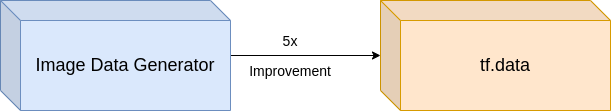

## Update: 24/11

* Using TTA * 15

## Update: 24/11

* Using EfficientNetB4
* Using TTA * 5

## Update: 15/11

* Using Mixed Precision Training
* Storing data cache in /kaggle folder as it has more memory available

## Update: 14/11

* I was shuffling the validation dataset too, hence that was a bug. 
* Trying out NS.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization, Activation
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras


import os

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


## Mixed Precision Training

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)

Adding Seed helps to reproduce results. Setting Debug Parameter will run the model on smaller number of epochs to validate the architecture.

In [ ]:
SEED = 42
DEBUG = False

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Prepare Data

In [ ]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df.head()

Distribution of dataset:

In [ ]:
df['path'] = '../input/cassava-leaf-disease-classification/train_images/' + df['image_id']
df.label.value_counts(normalize=True) * 100


In [ ]:
if DEBUG:
    _, df = train_test_split(df, test_size = 0.1, random_state=SEED, shuffle=True, stratify=df['label'])


## Data Loader using tf.Data

### Spliting Dataset

In [ ]:
X_train, X_valid = train_test_split(df, test_size = 0.1, random_state=SEED, shuffle=True)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train.path.values, X_train.label.values))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid.path.values, X_valid.label.values))

In [ ]:
for path, label in train_ds.take(5):
    print ('Path: {}, Label: {}'.format(path, label))

In [ ]:
for path, label in valid_ds.take(5):
    print ('Path: {}, Label: {}'.format(path, label))

### Data Generator

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

target_size_dim = 512

In [ ]:
def process_data_train(image_path, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_flip_left_right(img, seed=None)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_crop(img, size=[target_size_dim, target_size_dim, 3])
    return img, label

def process_data_valid(image_path, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [target_size_dim,target_size_dim])
    return img, label


In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_data_train, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(process_data_valid, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype('uint8'))
    plt.show()
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

### Improving Performance

In [ ]:
def configure_for_performance(ds, batch_size = 32):
    ds = ds.cache('/kaggle/dump.tfcache') 
    
    ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

batch_size = 8

train_ds_batch = configure_for_performance(train_ds, batch_size)
valid_ds_batch = valid_ds.batch(batch_size)

In [ ]:
image_batch, label_batch = next(iter(train_ds_batch))

In [ ]:

plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i].numpy()
    plt.title(label)
    plt.axis("off")

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, interpolation='nearest'),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2 ))
    ]
)

In [ ]:

plt.figure(figsize=(10, 10))
for i in range(8):
    augmented_images = data_augmentation(image_batch)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    label = label_batch[i].numpy()
    plt.title(label)
    plt.axis("off")

## Creating Model

In [ ]:
## Only available in tf2.3+

from tensorflow.keras.applications import EfficientNetB4


In [ ]:
def load_pretrained_model(weights_path, drop_connect, target_size_dim, layers_to_unfreeze=5):
    model = EfficientNetB4(
            weights=None, 
            include_top=False, 
            drop_connect_rate=0.4
        )
    
    model.load_weights(weights_path)
    
    model.trainable = True

    # for layer in model.layers[-layers_to_unfreeze:]:
    #     if not isinstance(layer, tf.keras.layers.BatchNormalization): 
    #         layer.trainable = True

    if DEBUG:
        for layer in model.layers:
            #print(layer.name, layer.trainable)
            pass

    return model

def build_my_model(base_model, optimizer, loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy']):
    
    inputs = tf.keras.layers.Input(shape=(target_size_dim, target_size_dim, 3))
    x = data_augmentation(inputs)
    outputs_eff = base_model(x)
    global_avg_pooling = GlobalAveragePooling2D()(outputs_eff)
    dense_1= Dense(256)(global_avg_pooling)
    bn_1 = BatchNormalization()(dense_1)
    activation = Activation('relu')(bn_1)
    dropout = Dropout(0.3)(activation)
    dense_2 = Dense(5)(dropout)
    outputs = Activation('softmax', dtype='float32', name='predictions')(dense_2)

    my_model = tf.keras.Model(inputs, outputs)
    
    my_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
        
    )
    return my_model



In [ ]:
#!wget https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5
## to get model weights

In [ ]:
model_weights_path = '../input/effnetb4-ns/effnetb4_ns.h5'
model_weights_path

In [ ]:
drop_rate = 0.4 ## value of dropout to be used in loaded network
base_model = load_pretrained_model( model_weights_path, drop_rate, target_size_dim )

optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
my_model = build_my_model(base_model, optimizer)
my_model.summary()

### Callbacks

In [ ]:
weight_path_save = 'best_model.hdf5'
last_weight_path = 'last_model.hdf5'

checkpoint = ModelCheckpoint(weight_path_save, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)
checkpoint_last = ModelCheckpoint(last_weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode= 'min', 
                             save_weights_only = False)


early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=5)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
callbacks_list = [checkpoint, checkpoint_last, early, reduceLROnPlat]

In [ ]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

## Train Model

In [ ]:
if DEBUG:
    epochs = 3
else:
    epochs = 15
    
print(f"Model will train for {epochs} epochs")

In [ ]:
if DEBUG:
    history = my_model.fit(train_ds_batch, 
                              validation_data = valid_ds_batch, 
                              epochs = epochs, 
                              callbacks = callbacks_list,
                               steps_per_epoch = 1,
                               
                           
                              )
else:
    history = my_model.fit(train_ds_batch, 
                              validation_data = valid_ds_batch, 
                              epochs = epochs, 
                              callbacks = callbacks_list
                               
                            
                              )

In [ ]:

def plot_hist(hist):
    plt.figure(figsize=(15,5))
    local_epochs = len(hist.history["sparse_categorical_accuracy"])
    plt.plot(np.arange(local_epochs, step=1), hist.history["sparse_categorical_accuracy"], '-o', label='Train Accuracy',color='#ff7f0e')
    plt.plot(np.arange(local_epochs, step=1), hist.history["val_sparse_categorical_accuracy"], '-o',label='Val Accuracy',color='#1f77b4')
    plt.xlabel('Epoch',size=14)
    plt.ylabel('Accuracy',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(local_epochs, step=1) ,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(local_epochs, step=1) ,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    plt.legend(loc=3)
    plt.ylabel('Loss',size=14)
    plt.title("Model Accuracy and loss")
    
    plt.savefig('loss.png')
    plt.show()

In [ ]:
plot_hist(history)

## Evaluating Model on Validation Set

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
my_model.load_weights(weight_path_save) ## load the best model or all your metrics would be on the last run not on the best one

In [ ]:
pred_valid_y = my_model.predict(valid_ds_batch, workers=4, verbose = True)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)

In [ ]:
valid_labels = np.concatenate([y.numpy() for x, y in valid_ds_batch], axis=0)

In [ ]:

print(classification_report(valid_labels, pred_valid_y_labels ))

In [ ]:
print(confusion_matrix(valid_labels, pred_valid_y_labels ))

## Predictions + Test Time Augmentation

In [ ]:
import glob

In [ ]:
test_images = glob.glob('../input/cassava-leaf-disease-classification/test_images/*.jpg')
#test_images = test_images * 5
print(test_images)

In [ ]:
df_test = pd.DataFrame(np.array(test_images), columns=['Path'])
df_test.head()

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((df_test.Path.values))


def process_test(image_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_flip_left_right(img, seed=None)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_crop(img, size=[target_size_dim, target_size_dim, 3])
    return img
    
test_ds = test_ds.map(process_test, num_parallel_calls=AUTOTUNE).batch(batch_size*2)

In [ ]:
preds = []
for i in range(5):
    
    pred_test = my_model.predict(test_ds, workers=16, verbose=1)
    preds.append(pred_test)
    

In [ ]:
pred_y = np.mean(preds, axis=0)

In [ ]:
#pred_y = my_model.predict(test_ds, workers=4)
pred_y_argmax = np.argmax(pred_y, axis=-1)

In [ ]:
df_test['image_id'] = df_test.Path.str.split('/').str[-1]
df_test['label'] = pred_y_argmax
df_test= df_test[['image_id','label']]
df_test.head()

In [ ]:
df_test.to_csv('submission.csv', index=False)



### If you learnt something from this kernel kindly upvote :) This keeps me motivated to produce more kernels.

My other Notebooks in this competition:

1. EfficientNetB3 Training with Pure Keras/tf2 ImageDataGenerator Method: [Link](https://www.kaggle.com/harveenchadha/efficientnetb3-keras-tf2-baseline-training)
2. EfficientNetB3 Inference with Pure Keras/tf2 ImageDataGenerator Method: [Link](https://www.kaggle.com/harveenchadha/efficientnetb3-baseline-inference-keras-tf2)

## Important Points:

1. ~~Due to Kaggle's space and RAM limitation, I could not make use of cache~~
2. ~~With the use of Cache, I can confirm I have achieved a 5x speed than ImageDataGenerator. Maybe I will do a kernel will small subset of the data confirming the same.~~

I am using cache now!